In [1]:
import matplotlib.pyplot as matPlt
import random
import numpy as np
import tensorflow as tf
import keras
from keras import layers

from tqdm.keras import TqdmCallback
from sklearn.metrics import confusion_matrix

import rasterio
from rasterio import plot as rastPlt
from rasterio.plot import reshape_as_raster
from rasterio.merge import merge as rasterMerge
from rasterio.mask import mask as rasterMask

from shapely.geometry import Polygon, box
import junodch_utils_read_img as utils

# Data preparation
### Fetch data from file

In [22]:
folderName = "img/Sokoto/"
pathSatellite = folderName + "Sentinel-2.tif"
#pathSatellite = folderName + "Landsat-8.tif"
pathNight = folderName + "Night_VIIRS_1.tif"
#pathNight = folderName + "lowres_night_1.tif"
pathValidation = folderName + "Population GHSL_1.tif"

aoi = utils.getImgBorder(pathSatellite)

# Fetch coords
dataCoords, dataRadiance = utils.getTilesCoordsPerimeter(pathNight, area=aoi)

print('Tiles:',dataCoords.shape[0])

Tiles: 554961


#### Validation

In [3]:
with rasterio.open(pathValidation) as f:
  testTile, _ = rasterMask(f, [Polygon(dataCoords[1000])], crop=True)
print('Validation shape:',testTile.shape) # shape sample

print('Process validation...')
getValid = lambda data : [ int(250/255 < img.max()) for img in data ]
resultValid = utils.scanSatellite(pathValidation, dataCoords, getValid, batch=1000, res=testTile.shape[1])

Validation shape: (4, 5, 5)
Process validation...


#### Fetch images

In [41]:
# Fetch images
lightMask = (dataRadiance>50) & (resultValid == 1)
lightCoords = dataCoords[lightMask]

idxDarkData = np.random.choice(np.arange(dataCoords.shape[0])[(dataRadiance<2) & (resultValid == 0)], 1500, replace=False)
darkCoords = dataCoords[idxDarkData]

trainCoords = np.concatenate((lightCoords, darkCoords))

with rasterio.open(pathSatellite) as f:
  trainData, _ = utils.coordsToImgsFormated(f, trainCoords, res=32)
print(trainData.shape)

print('Light Tile:',len(lightCoords))
print('dark Tile:',len(darkCoords))
print('Total train',trainData.shape)

train = trainData
validation = np.concatenate((dataRadiance[lightMask], dataRadiance[idxDarkData])).astype("float32") / 255

(3068, 32, 32, 3)
Light Tile: 1568
dark Tile: 1500
Total train (3068, 32, 32, 3)


## CNN

In [44]:
# Input encoder
input_shape = keras.Input(shape=trainData.shape[1:])

#optimizer = 'adam'
optimizer = keras.optimizers.Adam(
  learning_rate=0.001,
  beta_1=0.9,
  beta_2=0.999,
)
lossFunction = keras.losses.MeanSquaredError() # l2

activationFunction = 'relu'

earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=5)

cnn = layers.Conv2D(32,(3,3), 2, padding='same', activation=activationFunction)(input_shape)
cnn = layers.Conv2D(16,(3,3), 2, padding='same', activation=activationFunction)(cnn)
cnn = layers.Conv2D(8,(3,3), 2, padding='same', activation=activationFunction)(cnn)

cnn = layers.Flatten()(cnn)
cnn = layers.Dense(1, activation='sigmoid')(cnn)

modelCNN = keras.Model(input_shape, cnn)
modelCNN.compile(optimizer=optimizer, loss=lossFunction)

result = modelCNN.fit(
  x=train[::2],
  y=validation[::2],
  epochs=30,
  batch_size=10,
  shuffle=True,
  verbose=0,
  validation_data=(train[1::2], validation[1::2]),
  callbacks=[
    TqdmCallback(verbose=1), # Concise display progression
    earlyStop,
  ],
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 32)        896       
                                                                 
 conv2d_22 (Conv2D)          (None, 8, 8, 16)          4624      
                                                                 
 conv2d_23 (Conv2D)          (None, 4, 4, 8)           1160      
                                                                 
 flatten_7 (Flatten)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,809
Trainable params: 6,809
Non-trainable p

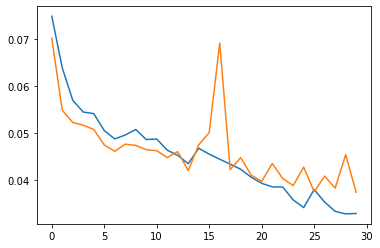

In [45]:
matPlt.plot(result.history['loss'][:], label='Training')
matPlt.plot(result.history['val_loss'][:], label='test')
modelCNN.summary()

In [46]:
print('Process score...')
getScore = lambda data : modelCNN.predict(data, verbose=0).flatten()
result = utils.scanSatellite(pathSatellite, dataCoords, getScore, batch=1000, res=32)

Process score...


In [50]:
print('Process confustion matrix...')
print(len(result))
resultTest = (np.asarray(result) > 0.4).astype(int)
confusionMatrix = confusion_matrix(resultValid, resultTest)
print(confusionMatrix)
#print((confusionMatrix[0][0] + confusionMatrix[1][1]) / (confusionMatrix[0][0] + confusionMatrix[0][1] + confusionMatrix[1][0] + confusionMatrix[1][1]),"%")
print((confusionMatrix[1][1]) / (confusionMatrix[0][1] + confusionMatrix[1][1]),"%")

Process confustion matrix...
554961
[[494349   8202]
 [ 50314   2096]]
0.20353466692561661 %


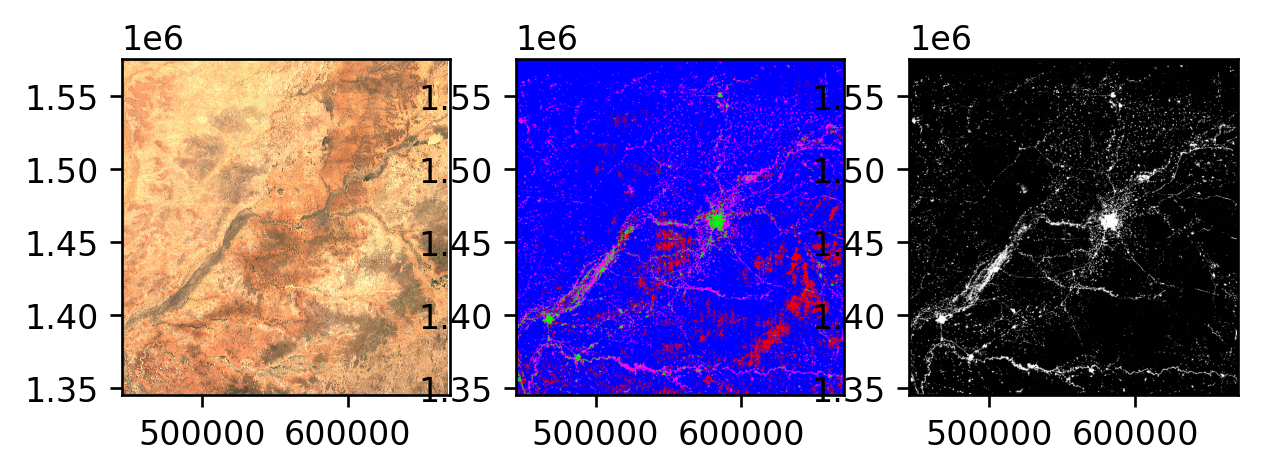

In [36]:
resultImg, resultMeta = utils.mapResultOnImg(pathNight, dataCoords, resultTest, resultValid)

fig, axs = matPlt.subplots(1,3, dpi=240)
with rasterio.open(pathSatellite) as s: utils.displayTiles([s.read()], [s.transform],axs[0])

axs[2].set_xlim(axs[0].get_xlim())
axs[2].set_ylim(axs[0].get_ylim())

with rasterio.open(pathValidation) as p: rastPlt.show(p, ax=axs[2])

axs[1].set_xlim(axs[0].get_xlim())
axs[1].set_ylim(axs[0].get_ylim())

utils.displayTiles([resultImg], [resultMeta], axs[1])

In [ ]:
img = np.copy(resultImg)
img = img[0:3,:,:]
img = img.transpose([1, 2, 0])
with rasterio.open(pathNight) as f:
  profile = f.profile
img = reshape_as_raster(img)
profile.update(count=3)
print(profile)
print(img.shape)

In [ ]:
with rasterio.open(folderName + 'test_32px_32_16_8.tif', 'w', **profile) as f:
  f.write(img)


In [ ]:
print(resultImg[:,301,340])